In [1]:
!unzip /content/traffic_data.zip

Archive:  /content/traffic_data.zip
   creating: traffic_data/
   creating: traffic_data/bus/
  inflating: traffic_data/bus/bus001.jpg  
  inflating: traffic_data/bus/bus002.jpg  
  inflating: traffic_data/bus/bus003.jpg  
  inflating: traffic_data/bus/bus004.jpg  
  inflating: traffic_data/bus/bus005.jpg  
  inflating: traffic_data/bus/bus006.jpg  
  inflating: traffic_data/bus/bus007.jpg  
  inflating: traffic_data/bus/bus008.jpg  
  inflating: traffic_data/bus/bus009.jpg  
  inflating: traffic_data/bus/bus010.jpg  
  inflating: traffic_data/bus/bus011.jpg  
  inflating: traffic_data/bus/bus012.jpg  
  inflating: traffic_data/bus/bus013.jpg  
  inflating: traffic_data/bus/bus014.jpg  
  inflating: traffic_data/bus/bus015.jpg  
  inflating: traffic_data/bus/bus016.jpg  
  inflating: traffic_data/bus/bus017.jpg  
  inflating: traffic_data/bus/bus018.jpg  
  inflating: traffic_data/bus/bus019.jpg  
  inflating: traffic_data/bus/bus020.jpg  
  inflating: traffic_data/bus/bus021.jpg  
  i

In [2]:
import torch
import numpy as np
import random
from matplotlib import pyplot as plt
import torch.utils.data as Data
from PIL import Image
import os
from torch import nn
import torch.optim as optim
from torch.nn import init
import torch.nn.functional as F
import time
import torchvision
from torchvision import transforms,datasets
from shutil import copy, rmtree
import json

In [3]:
def mk_file(file_path: str):
    if os.path.exists(file_path):
        rmtree(file_path)
    os.makedirs(file_path)
def split_data():
    split_rate = 0.25
    data_root = os.getcwd()
    origin_car_path = os.path.join(data_root, "traffic_data")
    assert os.path.exists(origin_car_path), "path '{}' does not exist.".format(origin_car_path)
    car_class = [cla for cla in os.listdir(origin_car_path) if os.path.isdir(os.path.join(origin_car_path, cla))]

  # 建立保存训练集的文件夹
    train_root = os.path.join(data_root, "train")
    mk_file(train_root)
    for cla in car_class:
  # 建立每个类别对应的文件夹
        mk_file(os.path.join(train_root, cla))

  # 建立保存验证集的文件夹
    test_root = os.path.join(data_root, "test")
    mk_file(test_root)
    for cla in car_class:
  # 建立每个类别对应的文件夹
        mk_file(os.path.join(test_root, cla))
    for cla in car_class:
        print(cla)
        cla_path = os.path.join(origin_car_path, cla)
        images = os.listdir(cla_path)
        num = len(images)
    # 随机采样验证集的索引
        eval_index = random.sample(images, k=int(num*split_rate))
        for index, image in enumerate(images):
            if image in eval_index:
      # 将分配至验证集中的文件复制到相应目录
                image_path = os.path.join(cla_path, image)
                new_path = os.path.join(test_root, cla)
                copy(image_path, new_path)
            else:
      # 将分配至训练集中的文件复制到相应目录
                image_path = os.path.join(cla_path, image)
                new_path = os.path.join(train_root, cla)
                copy(image_path, new_path)
            print("\r[{}] processing [{}/{}]".format(cla, index+1, num), end="")  # processing bar
    print("processing done!")
split_data()

bus
[bus] processing [219/219]truck
[truck] processing [360/360]car
[car] processing [779/779]processing done!


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

data_transform = {"train": transforms.Compose([transforms.Resize((64,64)),transforms.RandomHorizontalFlip(),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),
(0.5,0.5,0.5))]),"test": transforms.Compose([transforms.Resize((64,64)),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])}


image_path = os.getcwd()
print(image_path)
train_dataset = datasets.ImageFolder(root=os.path.join(image_path,"train"),transform = data_transform["train"])
train_num = len(train_dataset)
print(train_num)

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size = batch_size,shuffle = True,num_workers = 0)

test_dataset = datasets.ImageFolder(root=os.path.join(image_path,"test"),transform = data_transform["test"])

test_num = len(test_dataset)
print(test_num)#val_num = 364
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size = batch_size,shuffle=False,num_workers = 0)
print("using {} images for training, {} images for validation .".format(train_num,test_num))

using cuda:0 device.
/content
1019
338
using 1019 images for training, 338 images for validation .


In [21]:
class DilatedConvModule(nn.Module):  
    def __init__(self):
        super(DilatedConvModule,self).__init__()  
        #定义三层卷积层  
        self.conv = nn.Sequential(
        #第一层  
            nn.Conv2d(in_channels = 3,out_channels = 32,kernel_size = 3 ,stride = 1,padding = 0,dilation = 1),
            nn.BatchNorm2d(32),  
        # inplace-选择是否进行覆盖运算  
            nn.ReLU(inplace=True),  
        #第二层  
            nn.Conv2d(in_channels = 32,out_channels = 32,kernel_size = 3 ,stride = 1,padding = 0,dilation = 2),  
            nn.BatchNorm2d(32),  
            nn.ReLU(inplace=True),  
            nn.Conv2d(in_channels = 32,out_channels = 64,kernel_size = 3 ,stride = 1,padding = 0,dilation = 5),  
            nn.BatchNorm2d(64),  
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = 64,out_channels = 64,kernel_size = 3 ,stride = 1,padding = 0,dilation = 1),
            nn.BatchNorm2d(64),  
        # inplace-选择是否进行覆盖运算  
            nn.ReLU(inplace=True),  
        #第二层  
            nn.Conv2d(in_channels = 64,out_channels = 64,kernel_size = 3 ,stride = 1,padding = 0,dilation = 2),  
            nn.BatchNorm2d(64),  
            nn.ReLU(inplace=True),  
            nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 3 ,stride = 1,padding = 0,dilation = 5),  
            nn.BatchNorm2d(128),  
            nn.ReLU(inplace=True),)  
        self.fc = nn.Linear(128,3)  
    def forward(self,x):  
        #图片经过三层卷积，输出维度变为(batch_size,C_out,H,W)  
        out = self.conv(x)  
        #使用平均池化层将图片的大小变为1x1,第二个参数为最后输出的长和宽（这里默认相等了）（64-3）/1 + 1 =62  (62-3)/1+1 =60 (60-3)/1+1 =58  
        out = F.avg_pool2d(out,32)  
        #将张量out从shape batchx128x1x1 变为 batch x128  
        out = out.squeeze()  
        #输入到全连接层将输出的维度变为3  
        out = self.fc(out)  
        return out  


In [22]:
lr = 0.001
epochs = 20
num_class = 3
#初始化模型
net = DilatedConvModule().to(device)
#使用多元交叉熵损失函数
loss_func = nn.CrossEntropyLoss()
#使用Adam优化器
optimizer = optim.Adam(net.parameters(),lr = lr)

def train_epoch(net, data_loader, device):
    net.train() #指定当前为训练模式
    train_batch_num = len(data_loader) #记录共有多少个batch
    total_1oss = 0 #记录Loss
    correct = 0 #记录共有多少个样本被正确分类
    sample_num = 0 #记录样本总数
  #遍历每个batch进行训练
    for batch_idx, (data,target) in enumerate (data_loader):
        t1 = time.time()
        #将图片放入指定的device中
        data = data.to(device).float()
        #将图片标签放入指定的device中
        target = target.to(device).long()
        #将当前梯度清零
        optimizer.zero_grad()
        #使用模型计算出结果
        output = net(data)
        #计算损失
        loss = loss_func(output, target.squeeze())
        #进行反向传播
        loss.backward()
        optimizer.step()
        #累加loss
        total_1oss += loss.item()
        #找出每个样本值最大的idx,即代表预测此图片属于哪个类别
        prediction = torch.argmax(output, 1)
        #统计预测正确的类别数量
        correct += (prediction == target).sum().item()
        #累加当前的样本总数
        sample_num += len(prediction)
        #if batch_idx//5 ==0:
        t2 = time.time()
        #print("processing:{}/{},消耗时间{}s".format(batch_idx+1,len(data_loader),t2-t1))
    #计算平均loss与准确率
    loss = total_1oss / train_batch_num
    acc = correct / sample_num
    return loss, acc

def test_epoch(net, data_loader, device):
    net.eval() #指定当前模式为测试模式
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    #指定不进行梯度变化
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data = data.to(device).float()
            target = target.to(device).long()
            output = net(data)
            loss = loss_func(output, target)
            total_loss += loss.item( )
            prediction = torch.argmax(output, 1)
            correct += (prediction == target).sum().item()
            sample_num += len(prediction)
    loss = total_loss / test_batch_num
    acc = correct / sample_num
    return loss,acc

In [23]:
## 存储每一个epoch的loss与acc的变化，便于后面可视化
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
time_list = []
timestart = time.time()
print(device)
#进行训练
for epoch in range(epochs):
    #每一个epoch的开始时间
    time_start = time.time()
    #在训练集上训练  
    train_loss, train_acc = train_epoch(net,data_loader=train_loader, device=device)
    #在测试集上验证
    test_loss, test_acc = test_epoch(net,data_loader=test_loader, device=device)
    #每一个epoch的结束时间
    time_end = (time.time() - time_start)
    #保存各个指际
    train_loss_list.append(train_loss)  
    train_acc_list.append(train_acc )  
    test_loss_list.append(test_loss)  
    test_acc_list.append(test_acc)  
    time_list.append(time_end)  
    print('epoch %d, train_loss %.6f,test_loss %.6f,train_acc %.6f,test_acc %.6f,Time used %.6fs'%(epoch+1, train_loss,test_loss,train_acc,test_acc,time_end))  
#计算总时间  
timesum = (time.time() - timestart)  
print('The total time is %f s'%timesum) 

cuda:0
epoch 1, train_loss 0.556816,test_loss 0.557501,train_acc 0.791953,test_acc 0.775148,Time used 2.307503s
epoch 2, train_loss 0.368223,test_loss 0.431776,train_acc 0.849853,test_acc 0.816568,Time used 2.120183s
epoch 3, train_loss 0.322318,test_loss 0.304785,train_acc 0.882237,test_acc 0.881657,Time used 2.119229s
epoch 4, train_loss 0.268975,test_loss 0.519030,train_acc 0.905790,test_acc 0.766272,Time used 2.100574s
epoch 5, train_loss 0.232847,test_loss 0.258563,train_acc 0.920510,test_acc 0.893491,Time used 2.129252s
epoch 6, train_loss 0.210453,test_loss 0.243554,train_acc 0.925417,test_acc 0.923077,Time used 2.118424s
epoch 7, train_loss 0.200537,test_loss 0.326089,train_acc 0.922473,test_acc 0.896450,Time used 2.109940s
epoch 8, train_loss 0.165260,test_loss 0.273092,train_acc 0.942100,test_acc 0.908284,Time used 2.386804s
epoch 9, train_loss 0.159397,test_loss 0.245236,train_acc 0.941119,test_acc 0.920118,Time used 2.108215s
epoch 10, train_loss 0.125615,test_loss 0.185212

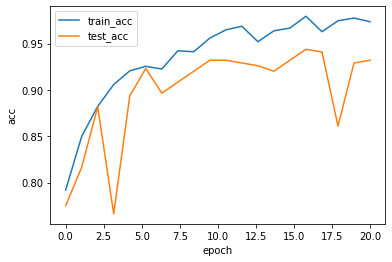

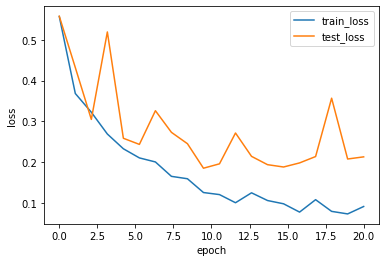

In [24]:
def Draw_Curve(*args,xlabel = "epoch",ylabel = "loss"):
    for i in args:
        x = np.linspace(0,len(i[0]),len(i[0]))
        plt.plot(x,i[0],label=i[1],linewidth=1.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()
Draw_Curve([train_acc_list,"train_acc"],[test_acc_list,"test_acc"],ylabel = "acc")
Draw_Curve([train_loss_list,"train_loss"],[test_loss_list,"test_loss"])


In [12]:
class ConvModule(nn.Module):  
    def __init__(self):
        super(ConvModule,self).__init__()  
        #定义三层卷积层  
        self.conv = nn.Sequential(
        #第一层  
            nn.Conv2d(in_channels = 3,out_channels = 32,kernel_size = 3 , stride = 1,padding=0),
            nn.BatchNorm2d(32),  
        # inplace-选择是否进行覆盖运算  
            nn.ReLU(inplace=True),  
        #第二层  
            nn.Conv2d(in_channels = 32,out_channels = 64, kernel_size = 3 , stride = 1,padding=0),  
            nn.BatchNorm2d(64),  
            nn.ReLU(inplace=True),  
            nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 3 , stride = 1,padding=0),  
            nn.BatchNorm2d(128),  
            nn.ReLU(inplace=True))  
        self.fc = nn.Linear(128,3)  
    def forward(self,x):  
        #图片经过三层卷积，输出维度变为(batch_size,C_out,H,W)  
        out = self.conv(x)  
        #使用平均池化层将图片的大小变为1x1,第二个参数为最后输出的长和宽（这里默认相等了）（64-3）/1 + 1 =62  (62-3)/1+1 =60 (60-3)/1+1 =58  
        out = F.avg_pool2d(out,58)  
        #将张量out从shape batchx128x1x1 变为 batch x128  
        out = out.squeeze()  
        #输入到全连接层将输出的维度变为3  
        out = self.fc(out)  
        return out  

lr = 0.001
epochs = 20
num_class = 3
#初始化模型
net = ConvModule().to(device)
#使用多元交叉熵损失函数
loss_func = nn.CrossEntropyLoss()
#使用Adam优化器
optimizer = optim.Adam(net.parameters(),lr = lr)

def train_epoch(net, data_loader, device):
    net.train() #指定当前为训练模式
    train_batch_num = len(data_loader) #记录共有多少个batch
    total_1oss = 0 #记录Loss
    correct = 0 #记录共有多少个样本被正确分类
    sample_num = 0 #记录样本总数
  #遍历每个batch进行训练
    for batch_idx, (data,target) in enumerate (data_loader):
        t1 = time.time()
        #将图片放入指定的device中
        data = data.to(device).float()
        #将图片标签放入指定的device中
        target = target.to(device).long()
        #将当前梯度清零
        optimizer.zero_grad()
        #使用模型计算出结果
        output = net(data)
        #计算损失
        loss = loss_func(output, target.squeeze())
        #进行反向传播
        loss.backward()
        optimizer.step()
        #累加loss
        total_1oss += loss.item()
        #找出每个样本值最大的idx,即代表预测此图片属于哪个类别
        prediction = torch.argmax(output, 1)
        #统计预测正确的类别数量
        correct += (prediction == target).sum().item()
        #累加当前的样本总数
        sample_num += len(prediction)
        #if batch_idx//5 ==0:
        t2 = time.time()
        #print("processing:{}/{},消耗时间{}s".format(batch_idx+1,len(data_loader),t2-t1))
    #计算平均loss与准确率
    loss = total_1oss / train_batch_num
    acc = correct / sample_num
    return loss, acc

def test_epoch(net, data_loader, device):
    net.eval() #指定当前模式为测试模式
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    #指定不进行梯度变化
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data = data.to(device).float()
            target = target.to(device).long()
            output = net(data)
            loss = loss_func(output, target)
            total_loss += loss.item( )
            prediction = torch.argmax(output, 1)
            correct += (prediction == target).sum().item()
            sample_num += len(prediction)
    loss = total_loss / test_batch_num
    acc = correct / sample_num
    return loss,acc

## 存储每一个epoch的loss与acc的变化，便于后面可视化
train_loss_list_ori = []
train_acc_list_ori = []
test_loss_list_ori = []
test_acc_list_ori = []
time_list_ori = []
timestart_ori = time.time()
print(device)
#进行训练
for epoch in range(epochs):
    #每一个epoch的开始时间
    time_start = time.time()
    #在训练集上训练  
    train_loss, train_acc = train_epoch(net,data_loader=train_loader, device=device)
    #在测试集上验证
    test_loss, test_acc = test_epoch(net,data_loader=test_loader, device=device)
    #每一个epoch的结束时间
    time_end = (time.time() - time_start)
    #保存各个指际
    train_loss_list_ori.append(train_loss)  
    train_acc_list_ori.append(train_acc)  
    test_loss_list_ori.append(test_loss)  
    test_acc_list_ori.append(test_acc)  
    time_list_ori.append(time_end)  
    print('epoch %d, train_loss %.6f,test_loss %.6f,train_acc %.6f,test_acc %.6f,Time used %.6fs'%(epoch+1, train_loss,test_loss,train_acc,test_acc,time_end))  
#计算总时间  
timesum = (time.time() - timestart_ori)  
print('The total time is %f s'%timesum) 

cuda:0
epoch 1, train_loss 0.672089,test_loss 0.693847,train_acc 0.751717,test_acc 0.701183,Time used 2.329636s
epoch 2, train_loss 0.553588,test_loss 0.526360,train_acc 0.812561,test_acc 0.804734,Time used 2.235992s
epoch 3, train_loss 0.499039,test_loss 0.502114,train_acc 0.830226,test_acc 0.822485,Time used 2.243294s
epoch 4, train_loss 0.491056,test_loss 0.484487,train_acc 0.831207,test_acc 0.825444,Time used 2.172499s
epoch 5, train_loss 0.428191,test_loss 0.404375,train_acc 0.849853,test_acc 0.849112,Time used 2.258470s
epoch 6, train_loss 0.419029,test_loss 0.393115,train_acc 0.840039,test_acc 0.852071,Time used 2.867068s
epoch 7, train_loss 0.399125,test_loss 0.425262,train_acc 0.853778,test_acc 0.869822,Time used 2.239818s
epoch 8, train_loss 0.388608,test_loss 0.342134,train_acc 0.856722,test_acc 0.872781,Time used 2.211920s
epoch 9, train_loss 0.351503,test_loss 0.399507,train_acc 0.876349,test_acc 0.837278,Time used 2.241181s
epoch 10, train_loss 0.330192,test_loss 0.384969

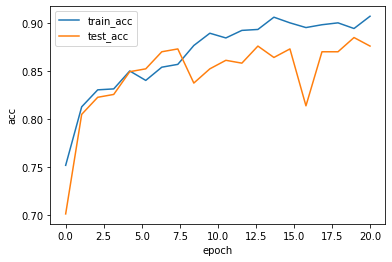

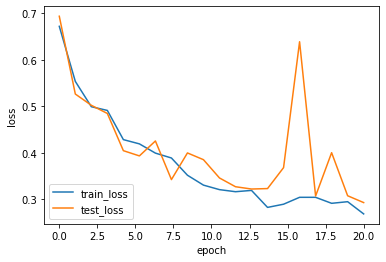

In [25]:
Draw_Curve([train_acc_list_ori,"train_acc"],[test_acc_list_ori,"test_acc"],ylabel = "acc")
Draw_Curve([train_loss_list_ori,"train_loss"],[test_loss_list_ori,"test_loss"])


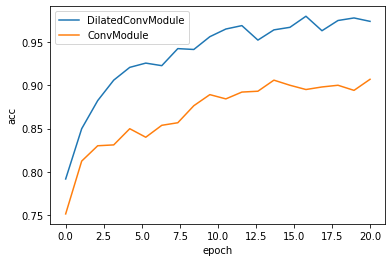

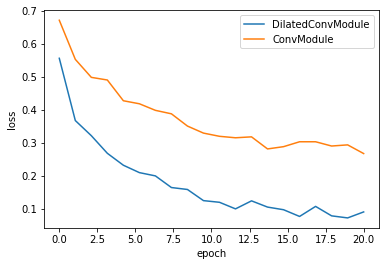

In [26]:
Draw_Curve([train_acc_list,"DilatedConvModule"],[train_acc_list_ori,"ConvModule"],ylabel = "acc")
Draw_Curve([train_loss_list,"DilatedConvModule"],[train_loss_list_ori,"ConvModule"])


In [28]:
class DilatedConvModuleL1(nn.Module):  
    def __init__(self):
        super(DilatedConvModuleL1,self).__init__()  
        #定义三层卷积层  
        self.conv = nn.Sequential(
        #第一层  
            nn.Conv2d(in_channels = 3,out_channels = 32,kernel_size = 3 ,stride = 1,padding = 0,dilation = 1),
            nn.BatchNorm2d(32),  
        # inplace-选择是否进行覆盖运算  
            nn.ReLU(inplace=True),  
        #第二层  
            nn.Conv2d(in_channels = 32,out_channels = 64,kernel_size = 3 ,stride = 1,padding = 0,dilation = 2),  
            nn.BatchNorm2d(64),  
            nn.ReLU(inplace=True),  
            nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 3 ,stride = 1,padding = 0,dilation = 5),  
            nn.BatchNorm2d(128),  
            nn.ReLU(inplace=True),
            )  
        self.fc = nn.Linear(128,3)  
    def forward(self,x):  
        #图片经过三层卷积，输出维度变为(batch_size,C_out,H,W)  
        out = self.conv(x)  
        #使用平均池化层将图片的大小变为1x1,第二个参数为最后输出的长和宽（这里默认相等了）（64-3）/1 + 1 =62  (62-3)/1+1 =60 (60-3)/1+1 =58  
        out = F.avg_pool2d(out,48)  
        #将张量out从shape batchx128x1x1 变为 batch x128  
        out = out.squeeze()  
        #输入到全连接层将输出的维度变为3  
        out = self.fc(out)  
        return out  

lr = 0.001
epochs = 20
num_class = 3
#初始化模型
net = DilatedConvModuleL1().to(device)
#使用多元交叉熵损失函数
loss_func = nn.CrossEntropyLoss()
#使用Adam优化器
optimizer = optim.Adam(net.parameters(),lr = lr)

def train_epoch(net, data_loader, device):
    net.train() #指定当前为训练模式
    train_batch_num = len(data_loader) #记录共有多少个batch
    total_1oss = 0 #记录Loss
    correct = 0 #记录共有多少个样本被正确分类
    sample_num = 0 #记录样本总数
  #遍历每个batch进行训练
    for batch_idx, (data,target) in enumerate (data_loader):
        t1 = time.time()
        #将图片放入指定的device中
        data = data.to(device).float()
        #将图片标签放入指定的device中
        target = target.to(device).long()
        #将当前梯度清零
        optimizer.zero_grad()
        #使用模型计算出结果
        output = net(data)
        #计算损失
        loss = loss_func(output, target.squeeze())
        #进行反向传播
        loss.backward()
        optimizer.step()
        #累加loss
        total_1oss += loss.item()
        #找出每个样本值最大的idx,即代表预测此图片属于哪个类别
        prediction = torch.argmax(output, 1)
        #统计预测正确的类别数量
        correct += (prediction == target).sum().item()
        #累加当前的样本总数
        sample_num += len(prediction)
        #if batch_idx//5 ==0:
        t2 = time.time()
        #print("processing:{}/{},消耗时间{}s".format(batch_idx+1,len(data_loader),t2-t1))
    #计算平均loss与准确率
    loss = total_1oss / train_batch_num
    acc = correct / sample_num
    return loss, acc

def test_epoch(net, data_loader, device):
    net.eval() #指定当前模式为测试模式
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    #指定不进行梯度变化
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data = data.to(device).float()
            target = target.to(device).long()
            output = net(data)
            loss = loss_func(output, target)
            total_loss += loss.item( )
            prediction = torch.argmax(output, 1)
            correct += (prediction == target).sum().item()
            sample_num += len(prediction)
    loss = total_loss / test_batch_num
    acc = correct / sample_num
    return loss,acc

## 存储每一个epoch的loss与acc的变化，便于后面可视化
train_loss_list_l1 = []
train_acc_list_l1 = []
test_loss_list_l1 = []
test_acc_list_l1 = []
time_list_l1 = []
timestart_l1 = time.time()
print(device)
#进行训练
for epoch in range(epochs):
    #每一个epoch的开始时间
    time_start = time.time()
    #在训练集上训练  
    train_loss, train_acc = train_epoch(net,data_loader=train_loader, device=device)
    #在测试集上验证
    test_loss, test_acc = test_epoch(net,data_loader=test_loader, device=device)
    #每一个epoch的结束时间
    time_end = (time.time() - time_start)
    #保存各个指际
    train_loss_list_l1.append(train_loss)  
    train_acc_list_l1.append(train_acc )  
    test_loss_list_l1.append(test_loss)  
    test_acc_list_l1.append(test_acc)  
    time_list_l1.append(time_end)  
    print('epoch %d, train_loss %.6f,test_loss %.6f,train_acc %.6f,test_acc %.6f,Time used %.6fs'%(epoch+1, train_loss,test_loss,train_acc,test_acc,time_end))  
#计算总时间  
timesum = (time.time() - timestart_l1)  
print('The total time is %f s'%timesum) 

cuda:0
epoch 1, train_loss 0.635631,test_loss 0.590905,train_acc 0.749755,test_acc 0.772189,Time used 2.215878s
epoch 2, train_loss 0.504769,test_loss 0.466989,train_acc 0.826300,test_acc 0.810651,Time used 2.048629s
epoch 3, train_loss 0.424235,test_loss 0.373321,train_acc 0.853778,test_acc 0.855030,Time used 2.067544s
epoch 4, train_loss 0.396656,test_loss 0.378296,train_acc 0.857704,test_acc 0.866864,Time used 1.980145s
epoch 5, train_loss 0.359061,test_loss 0.655704,train_acc 0.880275,test_acc 0.760355,Time used 2.018749s
epoch 6, train_loss 0.355797,test_loss 0.384304,train_acc 0.884200,test_acc 0.869822,Time used 2.046363s
epoch 7, train_loss 0.284095,test_loss 0.308352,train_acc 0.900883,test_acc 0.875740,Time used 2.057442s
epoch 8, train_loss 0.290260,test_loss 0.328178,train_acc 0.910697,test_acc 0.857988,Time used 2.169775s
epoch 9, train_loss 0.263852,test_loss 0.357324,train_acc 0.927380,test_acc 0.852071,Time used 2.089344s
epoch 10, train_loss 0.284486,test_loss 0.321118

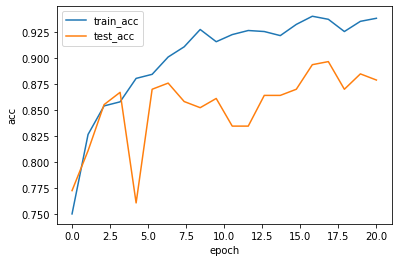

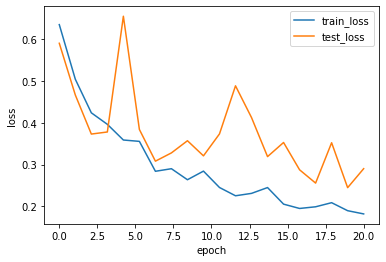

In [29]:
Draw_Curve([train_acc_list_l1,"train_acc"],[test_acc_list_l1,"test_acc"],ylabel = "acc")
Draw_Curve([train_loss_list_l1,"train_loss"],[test_loss_list_l1,"test_loss"])


In [30]:
class DilatedConvModuleL3(nn.Module):  
    def __init__(self):
        super(DilatedConvModuleL1,self).__init__()  
        #定义三层卷积层  
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels = 3,out_channels = 32,kernel_size = 3 ,stride = 1,padding = 0,dilation = 1),
            nn.BatchNorm2d(32),  
            nn.ReLU(inplace=True),  
            nn.Conv2d(in_channels = 32,out_channels = 32,kernel_size = 3 ,stride = 1,padding = 0,dilation = 2),  
            nn.BatchNorm2d(32),  
            nn.ReLU(inplace=True),  
            nn.Conv2d(in_channels = 32,out_channels = 64,kernel_size = 3 ,stride = 1,padding = 0,dilation = 5),  
            nn.BatchNorm2d(64),  
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels = 64,out_channels = 64,kernel_size = 3 ,stride = 1,padding = 0,dilation = 1),
            nn.BatchNorm2d(64),  
            nn.ReLU(inplace=True),  
            nn.Conv2d(in_channels = 64,out_channels = 64,kernel_size = 3 ,stride = 1,padding = 0,dilation = 2),  
            nn.BatchNorm2d(64),  
            nn.ReLU(inplace=True),  
            nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 3 ,stride = 1,padding = 0,dilation = 5),  
            nn.BatchNorm2d(128),  
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels = 128,out_channels = 128,kernel_size = 3 ,stride = 1,padding = 0,dilation = 1),
            nn.BatchNorm2d(128),  
            nn.ReLU(inplace=True),  
            nn.Conv2d(in_channels = 128,out_channels = 164,kernel_size = 3 ,stride = 1,padding = 0,dilation = 2),  
            nn.BatchNorm2d(164),  
            nn.ReLU(inplace=True),  
            nn.Conv2d(in_channels = 164,out_channels = 128,kernel_size = 3 ,stride = 1,padding = 0,dilation = 5),  
            nn.BatchNorm2d(128),  
            nn.ReLU(inplace=True),
            )  
        self.fc = nn.Linear(128,3)  
    def forward(self,x):  
        #图片经过三层卷积，输出维度变为(batch_size,C_out,H,W)  
        out = self.conv(x)  
        #使用平均池化层将图片的大小变为1x1,第二个参数为最后输出的长和宽（这里默认相等了）（64-3）/1 + 1 =62  (62-3)/1+1 =60 (60-3)/1+1 =58  
        out = F.avg_pool2d(out,16)  
        #将张量out从shape batchx128x1x1 变为 batch x128  
        out = out.squeeze()  
        #输入到全连接层将输出的维度变为3  
        out = self.fc(out)  
        return out  

lr = 0.001
epochs = 20
num_class = 3
#初始化模型
net = DilatedConvModuleL1().to(device)
#使用多元交叉熵损失函数
loss_func = nn.CrossEntropyLoss()
#使用Adam优化器
optimizer = optim.Adam(net.parameters(),lr = lr)

def train_epoch(net, data_loader, device):
    net.train() #指定当前为训练模式
    train_batch_num = len(data_loader) #记录共有多少个batch
    total_1oss = 0 #记录Loss
    correct = 0 #记录共有多少个样本被正确分类
    sample_num = 0 #记录样本总数
  #遍历每个batch进行训练
    for batch_idx, (data,target) in enumerate (data_loader):
        t1 = time.time()
        #将图片放入指定的device中
        data = data.to(device).float()
        #将图片标签放入指定的device中
        target = target.to(device).long()
        #将当前梯度清零
        optimizer.zero_grad()
        #使用模型计算出结果
        output = net(data)
        #计算损失
        loss = loss_func(output, target.squeeze())
        #进行反向传播
        loss.backward()
        optimizer.step()
        #累加loss
        total_1oss += loss.item()
        #找出每个样本值最大的idx,即代表预测此图片属于哪个类别
        prediction = torch.argmax(output, 1)
        #统计预测正确的类别数量
        correct += (prediction == target).sum().item()
        #累加当前的样本总数
        sample_num += len(prediction)
        #if batch_idx//5 ==0:
        t2 = time.time()
        #print("processing:{}/{},消耗时间{}s".format(batch_idx+1,len(data_loader),t2-t1))
    #计算平均loss与准确率
    loss = total_1oss / train_batch_num
    acc = correct / sample_num
    return loss, acc

def test_epoch(net, data_loader, device):
    net.eval() #指定当前模式为测试模式
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    #指定不进行梯度变化
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data = data.to(device).float()
            target = target.to(device).long()
            output = net(data)
            loss = loss_func(output, target)
            total_loss += loss.item( )
            prediction = torch.argmax(output, 1)
            correct += (prediction == target).sum().item()
            sample_num += len(prediction)
    loss = total_loss / test_batch_num
    acc = correct / sample_num
    return loss,acc

## 存储每一个epoch的loss与acc的变化，便于后面可视化
train_loss_list_l3 = []
train_acc_list_l3 = []
test_loss_list_l3 = []
test_acc_list_l3 = []
time_list_l3 = []
timestart_l3 = time.time()
print(device)
#进行训练
for epoch in range(epochs):
    #每一个epoch的开始时间
    time_start = time.time()
    #在训练集上训练  
    train_loss, train_acc = train_epoch(net,data_loader=train_loader, device=device)
    #在测试集上验证
    test_loss, test_acc = test_epoch(net,data_loader=test_loader, device=device)
    #每一个epoch的结束时间
    time_end = (time.time() - time_start)
    #保存各个指际
    train_loss_list_l3.append(train_loss)  
    train_acc_list_l3.append(train_acc )  
    test_loss_list_l3.append(test_loss)  
    test_acc_list_l3.append(test_acc)  
    time_list_l3.append(time_end)  
    print('epoch %d, train_loss %.6f,test_loss %.6f,train_acc %.6f,test_acc %.6f,Time used %.6fs'%(epoch+1, train_loss,test_loss,train_acc,test_acc,time_end))  
#计算总时间  
timesum = (time.time() - timestart_l3)  
print('The total time is %f s'%timesum) 

cuda:0
epoch 1, train_loss 0.636601,test_loss 0.843389,train_acc 0.765456,test_acc 0.612426,Time used 2.225029s
epoch 2, train_loss 0.474131,test_loss 0.428385,train_acc 0.842983,test_acc 0.840237,Time used 2.047004s
epoch 3, train_loss 0.414676,test_loss 0.380107,train_acc 0.850834,test_acc 0.852071,Time used 2.051324s
epoch 4, train_loss 0.383308,test_loss 0.344518,train_acc 0.862610,test_acc 0.852071,Time used 2.074945s
epoch 5, train_loss 0.343908,test_loss 0.553357,train_acc 0.876349,test_acc 0.760355,Time used 2.097498s
epoch 6, train_loss 0.362940,test_loss 0.469002,train_acc 0.870461,test_acc 0.810651,Time used 2.111226s
epoch 7, train_loss 0.303341,test_loss 0.284755,train_acc 0.897939,test_acc 0.878698,Time used 2.119435s
epoch 8, train_loss 0.281492,test_loss 0.331464,train_acc 0.904809,test_acc 0.890533,Time used 2.138979s
epoch 9, train_loss 0.281730,test_loss 0.295599,train_acc 0.904809,test_acc 0.896450,Time used 2.040991s
epoch 10, train_loss 0.270567,test_loss 0.303294

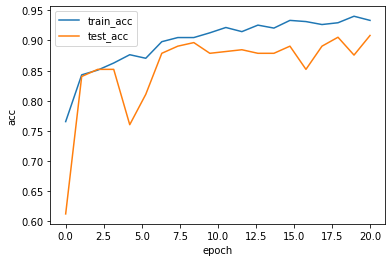

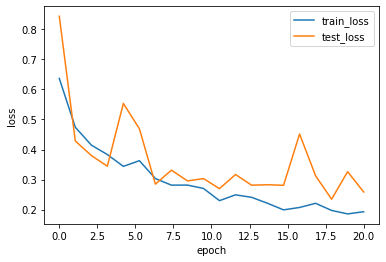

In [31]:
Draw_Curve([train_acc_list_l3,"train_acc"],[test_acc_list_l3,"test_acc"],ylabel = "acc")
Draw_Curve([train_loss_list_l3,"train_loss"],[test_loss_list_l3,"test_loss"])


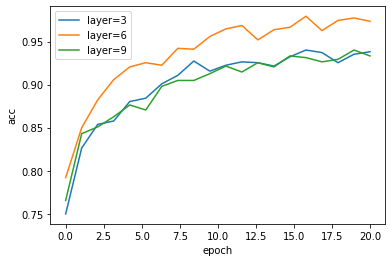

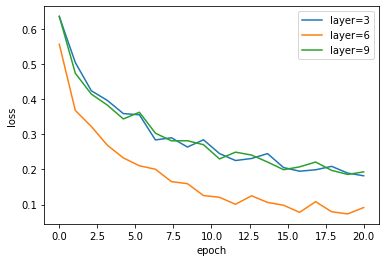

In [32]:
Draw_Curve([train_acc_list_l1,"layer=3"],[train_acc_list,"layer=6"],[train_acc_list_l3,"layer=9"],ylabel = "acc")
Draw_Curve([train_loss_list_l1,"layer=3"],[train_loss_list,"layer=6"],[train_loss_list_l3,"layer=9"])
